In [ ]:
!pip install torchaudio==0.13.0
!pip install torchphysics


# Exercise Sheet 3

### 3.1 ODE with a time dependent Parameter
Use TorchPhysics to solve the ODE for falling with a parachute:
\begin{align*}
    \partial_t^2 u(t) &= D(t)(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}
Where now $D: \R \to \R$ with $ D(t) = 2.0\cdot(1.1 + \sin(4\cdot t))$.

In [56]:
import torch
import torchphysics as tp
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0

### TODO: implement the function of D.
def D(t):
    return 2.0 * (1.1 + torch.sin(4 * t))

g, H = 9.81, 50.0

# number of time points
N_t = 500
N_initial = 1

train_iterations = 10000
learning_rate = 1.e-3

In [57]:
### Spaces, Domains and Sampler like yesterday:
### TODO: For part b) add space and domain for initial velocity v_0. Then add it to the samplers.
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')

int_t = tp.domains.Interval(T, t_min, t_max)
int_v = tp.domains.Interval(V, -10.0, 0.0)

ode_sampler = tp.samplers.RandomUniformSampler(int_t*int_v, n_points=N_t)
initial_sampler = tp.samplers.RandomUniformSampler(int_t.boundary_left * int_v, n_points=N_t)
velocity_sampler = tp.samplers.RandomUniformSampler(int_t.boundary_left * int_v, n_points=N_t)

In [58]:
### TODO: Create the neural network with 3 hidden layers and 25 neurons each.
###       For b) the input space should include v_0.
model = tp.models.FCN(input_space=T * V,
                      output_space=U,
                      hidden=(25,25,25))

In [59]:
### TODO: Define condition for the ODE:
def ode_residual(u,t):
  return tp.utils.laplacian(u,t)- D(t) * (tp.utils.grad(u,t)) ** 2 + g


ode_condition = tp.conditions.PINNCondition(model,
                                    ode_sampler,
                                    ode_residual)

In [60]:
### Other conditions are also like before:
def position_residual(u):
    return u - H

initial_position_condition = tp.conditions.PINNCondition(model, initial_sampler, position_residual)

In [63]:
### TODO: For b) implement here the initial velocity condition
def velocity_residual(u, t , v):
    return tp.utils.grad(u, t) - v

initial_velocity_condition = tp.conditions.PINNCondition(model, velocity_sampler, velocity_residual)

In [64]:
### Syntax for the training is already implemented:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver([ode_condition, initial_position_condition, initial_velocity_condition],
                          optimizer_setting=optim)

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     benchmark=True,
                     max_steps=train_iterations,
                     logger=False)

trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summar

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10000` reached.


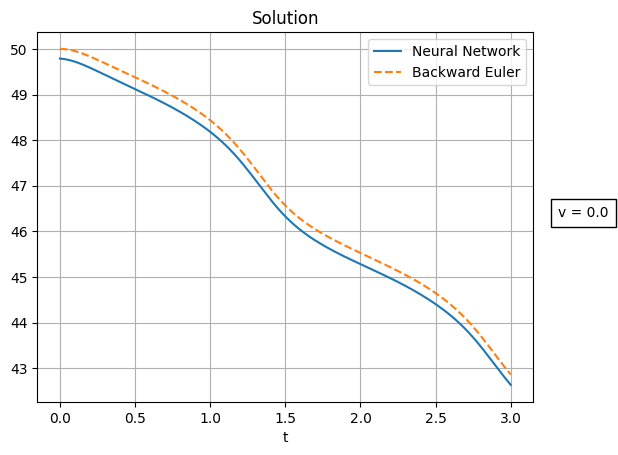

In [67]:
### Here, plot the solution:
import matplotlib.pyplot as plt

v_0_test = 0.0

# If the solution is dependent on the inital velocity add:
data_for_other_variables={"v":v_0_test}
plot_sampler = tp.samplers.PlotSampler(int_t, 200, data_for_other_variables=data_for_other_variables)
fig = tp.utils.plot(model, lambda u: u, plot_sampler)
plt.title("Solution")

# Solution for comparision with backward euler:
t = torch.linspace(t_min, t_max, 2000)
dt = t[1] - t[0]
D_fn = D(t)
u, v = torch.zeros_like(t), torch.zeros_like(t)
u[0] = H
v[0] = v_0_test
for i in range(len(t)-1):
    v[i+1] = 1/(2*dt*D_fn[i+1]) - torch.sqrt(1/(2*dt*D_fn[i+1])**2 - (v[i] - dt*g)/(dt*D_fn[i+1]))
    u[i+1] = u[i] + dt * v[i+1]

plt.plot(t, u, linestyle="--")
plt.legend(["Neural Network", "Backward Euler"])